In [64]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from scipy.stats import ttest_ind, norm
from sklearn.feature_selection import f_regression, RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score, silhouette_score, adjusted_rand_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
import ipywidgets as widgets
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from mlxtend.frequent_patterns import apriori, association_rules

# Phase I

## Data Overview

Our raw dataset contains multiple tables, which we will later use to create a single table for our analysis

In [3]:
heartrate_seconds = pd.read_csv('data/heartrate_seconds_merged.csv')
print(f'Number of observations in the dataset: {len(heartrate_seconds)}')
heartrate_seconds.head()

Number of observations in the dataset: 2483658


,Id,Time,Value
0,2022484408,4/12/2016 7:21:00 AM,97
1,2022484408,4/12/2016 7:21:05 AM,102
2,2022484408,4/12/2016 7:21:10 AM,105
3,2022484408,4/12/2016 7:21:20 AM,103
4,2022484408,4/12/2016 7:21:25 AM,101


In [4]:
unique_users_heartrate_seconds = heartrate_seconds["Id"].unique()
print(f'Id of unique users in the dataset: {", ".join([str(x) for x in unique_users_heartrate_seconds])}')
print(f'\nNumber of unique users in the dataset: {len(unique_users_heartrate_seconds)}')

Id of unique users in the dataset: 2022484408, 2026352035, 2347167796, 4020332650, 4388161847, 4558609924, 5553957443, 5577150313, 6117666160, 6775888955, 6962181067, 7007744171, 8792009665, 8877689391

Number of unique users in the dataset: 14


In [5]:
daily_activity = pd.read_csv('data/dailyActivity_merged.csv')
print(f'Number of observations in the dataset: {len(daily_activity)}')
daily_activity.head()

Number of observations in the dataset: 940


,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [6]:
unique_users_daily_activity = daily_activity["Id"].unique()
print(f'Id of unique users in the dataset: {", ".join([str(x) for x in unique_users_daily_activity])}')
print(f'\nNumber of unique users in the dataset: {len(unique_users_daily_activity)}')

Id of unique users in the dataset: 1503960366, 1624580081, 1644430081, 1844505072, 1927972279, 2022484408, 2026352035, 2320127002, 2347167796, 2873212765, 3372868164, 3977333714, 4020332650, 4057192912, 4319703577, 4388161847, 4445114986, 4558609924, 4702921684, 5553957443, 5577150313, 6117666160, 6290855005, 6775888955, 6962181067, 7007744171, 7086361926, 8053475328, 8253242879, 8378563200, 8583815059, 8792009665, 8877689391

Number of unique users in the dataset: 33


In [7]:
unique_users = np.intersect1d(unique_users_heartrate_seconds, unique_users_daily_activity)
print(f'Id of unique users whose data is present in both datasets: {", ".join([str(x) for x in unique_users])}')
print(f'\nNumber of unique users whose data is present in both datasets: {len(unique_users)}')

Id of unique users whose data is present in both datasets: 2022484408, 2026352035, 2347167796, 4020332650, 4388161847, 4558609924, 5553957443, 5577150313, 6117666160, 6775888955, 6962181067, 7007744171, 8792009665, 8877689391

Number of unique users whose data is present in both datasets: 14


So all users in the unique_users_heartrate_seconds table are also in the daily_activity dataset.

## Preprocessing

### Format the dates and time

In [8]:
format_string = '%m/%d/%Y %I:%M:%S %p'
heartrate_seconds_formatted = pd.DataFrame(heartrate_seconds)
heartrate_seconds_formatted['Time'] = pd.to_datetime(heartrate_seconds['Time'], format=format_string)

In [9]:
format_string = '%m/%d/%Y'
daily_activity_formatted = pd.DataFrame(daily_activity)
daily_activity_formatted['ActivityDate'] = pd.to_datetime(daily_activity['ActivityDate'], format=format_string)

### Aggregate the data by users and 5-min intervals using the mean heart rate

The idea is to predict average heart rate for 5-minute interval runs using activity data of users. We will incorporate features taken from related tables.

In [10]:
# group the data by Id and 5 min intervals, and calculate the average heart rate for each group
heartrate_seconds_grouped = heartrate_seconds_formatted.groupby(['Id', pd.Grouper(key='Time', freq='5Min')])['Value'].mean()

# create a new dataframe with the aggregated data
heartrate_seconds_grouped_df = pd.DataFrame(heartrate_seconds_grouped.rename('Average Heart Rate'))

# extract date from Time column in the table
heartrate_seconds_grouped_df['ActivityDate'] = pd.to_datetime(pd.to_datetime(
    heartrate_seconds_grouped.index.get_level_values('Time')).date)

# print the resulting dataframe
heartrate_seconds_grouped_df

Average Heart Rate ActivityDate
Id         Time                                                
2022484408 2016-04-12 07:20:00           76.730769   2016-04-12
           2016-04-12 07:25:00           61.600000   2016-04-12
           2016-04-12 07:30:00           78.000000   2016-04-12
           2016-04-12 07:35:00           81.292683   2016-04-12
           2016-04-12 07:40:00           88.444444   2016-04-12
...                                            ...          ...
8877689391 2016-05-12 14:20:00           58.583333   2016-05-12
           2016-05-12 14:25:00           60.078947   2016-05-12
           2016-05-12 14:30:00           90.285714   2016-05-12
           2016-05-12 14:35:00           65.282051   2016-05-12
           2016-05-12 14:40:00           56.687500   2016-05-12

[67518 rows x 2 columns]

### Anomaly detection

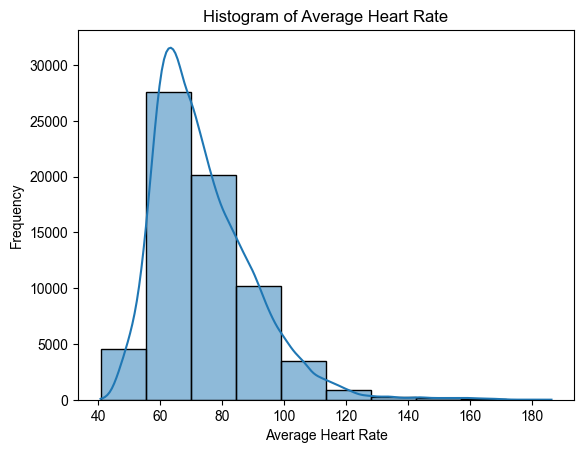

In [11]:
sns.histplot(data=heartrate_seconds_grouped_df, x='Average Heart Rate', bins=10, kde=True)
sns.set_style('darkgrid')
plt.xlabel('Average Heart Rate')
plt.ylabel('Frequency')
plt.title('Histogram of Average Heart Rate')
plt.show()

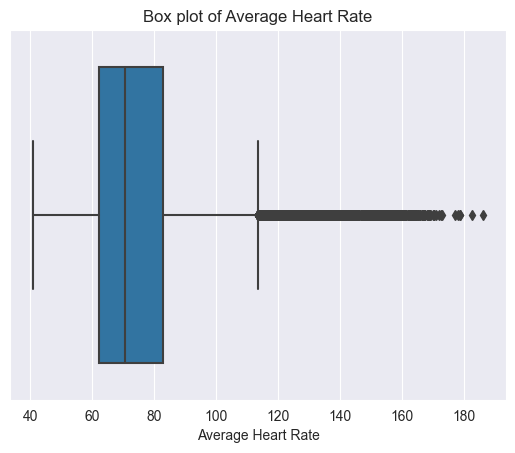

In [12]:
sns.boxplot(x=heartrate_seconds_grouped_df['Average Heart Rate'])
sns.set_style('darkgrid')
plt.xlabel('Average Heart Rate')
plt.title('Box plot of Average Heart Rate')
plt.show()

Even though this plot shows outliers, The maximum average heart rate shown is not really considered an anomaly (from domain knowledge). So we do not remove the points on this basis, but will try this approach in our experiments.

### Merge datasets

In [13]:
df = pd.merge(heartrate_seconds_grouped_df, daily_activity_formatted, on=['Id', 'ActivityDate'], how='inner')
df

,Id,Average Heart Rate,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,2022484408,76.730769,2016-04-12,11875,8.34,8.34,0.0,3.31,0.77,4.26,0.0,42,14,227,1157,2390
1,2022484408,61.600000,2016-04-12,11875,8.34,8.34,0.0,3.31,0.77,4.26,0.0,42,14,227,1157,2390
2,2022484408,78.000000,2016-04-12,11875,8.34,8.34,0.0,3.31,0.77,4.26,0.0,42,14,227,1157,2390
3,2022484408,81.292683,2016-04-12,11875,8.34,8.34,0.0,3.31,0.77,4.26,0.0,42,14,227,1157,2390
4,2022484408,88.444444,2016-04-12,11875,8.34,8.34,0.0,3.31,0.77,4.26,0.0,42,14,227,1157,2390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67513,8877689391,58.583333,2016-05-12,8064,6.12,6.12,0.0,1.82,0.04,4.25,0.0,23,1,137,770,1849
67514,8877689391,60.078947,2016-05-12,8064,6.12,6.12,0.0,1.82,0.04,4.25,0.0,23,1,137,770,1849
67515,8877689391,90.285714,2016-05-12,8064,6.12,6.12,0.0,1.82,0.04,4.25,0.0,23,1,137,770,1849
67516,8877689391,65.282051,2016-05-12,8064,6.12,6.12,0.0,1.82,0.04,4.25,0.0,23,1,137,770,1849


This is the dataset we will use for our analysis.

### Missing values?

In [14]:
df.isna().sum()

Id                          0
Average Heart Rate          0
ActivityDate                0
TotalSteps                  0
TotalDistance               0
TrackerDistance             0
LoggedActivitiesDistance    0
VeryActiveDistance          0
ModeratelyActiveDistance    0
LightActiveDistance         0
SedentaryActiveDistance     0
VeryActiveMinutes           0
FairlyActiveMinutes         0
LightlyActiveMinutes        0
SedentaryMinutes            0
Calories                    0
dtype: int64

We don't have any missing values

## EDA

### Heartrate as timeseries (just for visualization)

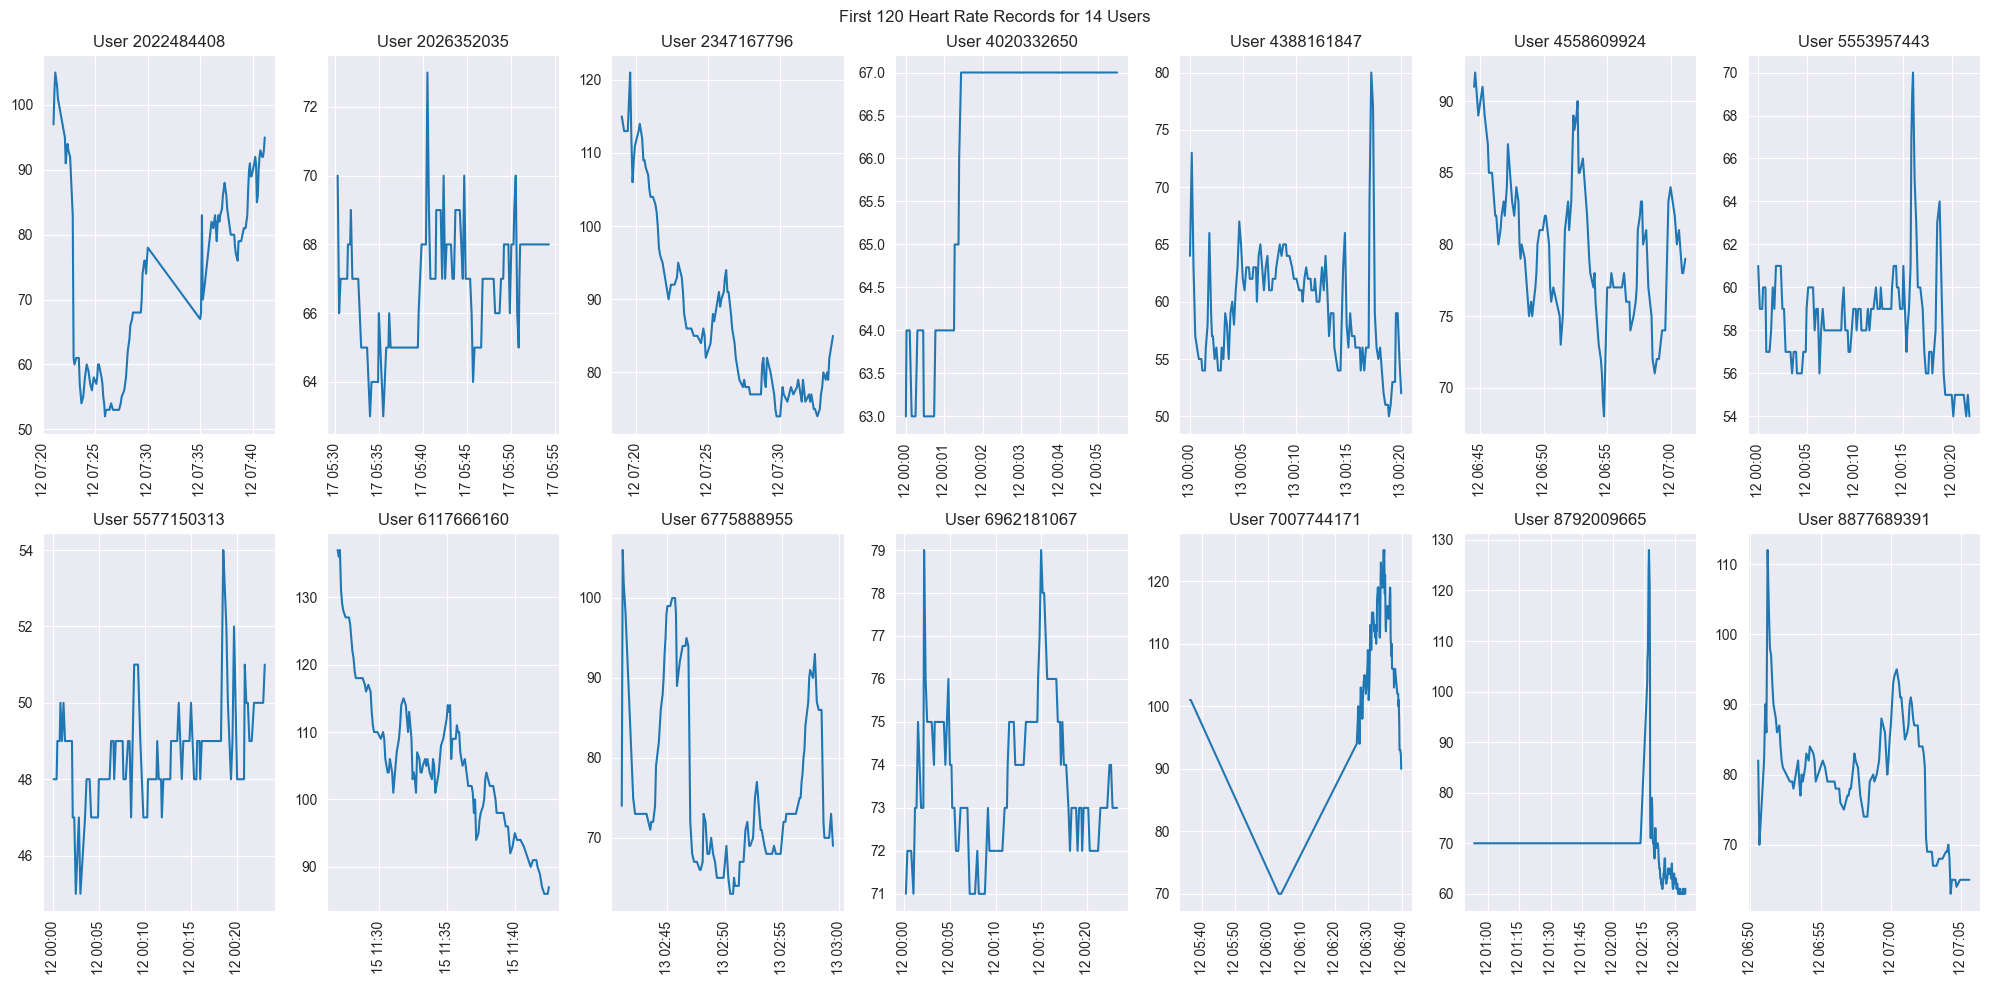

In [15]:
# create a figure with 14 subplots, arranged in 2 rows and 7 columns
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(20,10))

# flatten the axes array for easy indexing
axes = axes.flatten()

# loop over the unique Id values in the data
for i, id in enumerate(heartrate_seconds_formatted['Id'].unique()):
    # select the heart rate data for this user and the first 120 records
    data = heartrate_seconds_formatted.loc[heartrate_seconds_formatted['Id'] == id][['Time', 'Value']][0:120]
    
    data.set_index('Time', inplace=True)
    
    # plot the data on the appropriate subplot
    axes[i].plot(data)
    axes[i].set_title(f"User {id}")
    
    # label time vertically
    axes[i].tick_params(axis='x', rotation=90)

# add a global title to the figure
fig.suptitle("First 120 Heart Rate Records for 14 Users")
# adjust the spacing between subplots to avoid overlapping axis labels
plt.tight_layout()
# display the plot
plt.show()


### Feature importance for predicting Calories (burned) for the daily_activity table

Even though Calories is not what we are trying to predict but the average heart rate, we do the following experiment in hopes to gain insights:

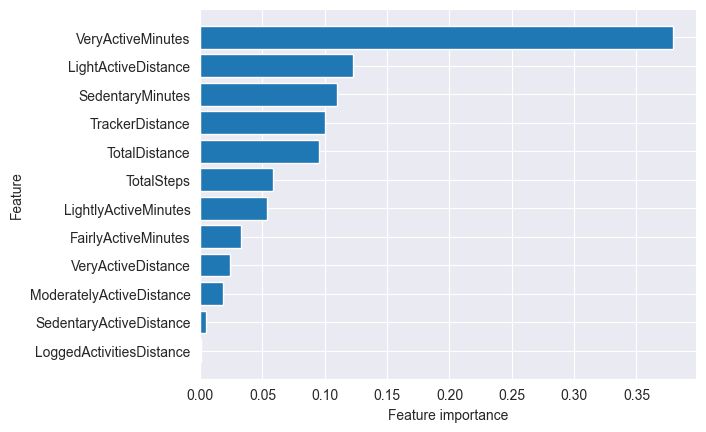

In [16]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)

X = daily_activity[['TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes']]

y = daily_activity['Calories']

# Train the model on the training data
rf.fit(X, y)

# Get the feature importances
importances = rf.feature_importances_

sorted_idx = importances.argsort()

# Plot the feature importances
plt.barh(range(X.shape[1]), importances[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), X.columns[sorted_idx])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

### Select important features from the merged table (df)

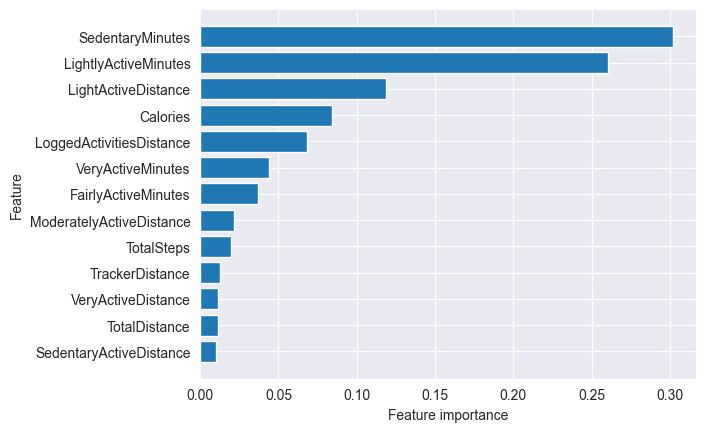

In [17]:
rf = RandomForestRegressor(n_estimators=100, random_state=1)

X = df[['TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']]

y = df['Average Heart Rate']

# Train the model on the training data
rf.fit(X, y)

# Get the feature importances
importances = rf.feature_importances_

sorted_idx = importances.argsort()

# Plot the feature importances
plt.barh(range(X.shape[1]), importances[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), X.columns[sorted_idx])
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.show()

In [18]:
important_features = list(X.columns[importances > 0.03])
print(f'Important features: {important_features}')

selected_columns = important_features + ['Average Heart Rate']

Important features: ['LoggedActivitiesDistance', 'LightActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']


In [19]:
df_important = df.loc[:, selected_columns]
df_important

,LoggedActivitiesDistance,LightActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,Average Heart Rate
0,0.0,4.26,42,14,227,1157,2390,76.730769
1,0.0,4.26,42,14,227,1157,2390,61.600000
2,0.0,4.26,42,14,227,1157,2390,78.000000
3,0.0,4.26,42,14,227,1157,2390,81.292683
4,0.0,4.26,42,14,227,1157,2390,88.444444
...,...,...,...,...,...,...,...,...
67513,0.0,4.25,23,1,137,770,1849,58.583333
67514,0.0,4.25,23,1,137,770,1849,60.078947
67515,0.0,4.25,23,1,137,770,1849,90.285714
67516,0.0,4.25,23,1,137,770,1849,65.282051


### Standardize the data

In [20]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_important.drop(columns=['Average Heart Rate']), df_important['Average Heart Rate'], test_size=0.2, random_state=1)

In [21]:
feature_names = df_important.drop(columns=['Average Heart Rate']).columns

In [22]:
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

# transform the training and test data
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

### Sample covariance matrix heatmap graph

<AxesSubplot: >

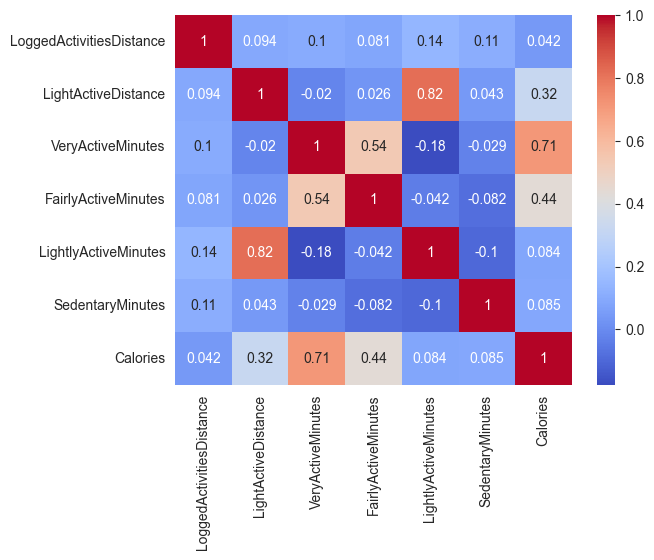

In [23]:
cov_mat = pd.DataFrame(X_train_std, columns=feature_names).cov()

# plot the heatmap
sns.heatmap(cov_mat, annot=True, cmap='coolwarm')

Main observations:
* LightActiveDistance is highly correlated with LightlyActiveMinutes, which is positively correlated with Calories.
* Calories is highly correlated with VeryActiveMinutes, which is in turn correlated with FairlyActiveMinutes.

General conclusion:
* A lot of features are correlated to each other.

## Feature Engineering

### Basic experiment

In [24]:
model = LinearRegression()
model.fit(X_train_std, y_train)

# Evaluate the model on the test data
y_pred = model.predict(X_test_std)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean squared error: 215.8596
R-squared: 0.1490


This error is really high.

### Further experiments

In [25]:
# Create a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the standardized training data
model.fit(X_train, y_train)

# Evaluate the model on the standardized test data
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean squared error: 181.4232
R-squared: 0.2847


This performs much better than the linear model, but still not good enough.

It is likely that the presence of multiple occurrences of sets of features that predict different average heart rates (as it does in our dataset) is negatively affecting the performance of our linear regression model (because linear regression assumes that there is a linear relationship between the independent variables and the target variable). This suggests that would benefit if our model had an "averaging" nature.

Overall, the experiments and our insights suggest that we use an ensemble model involving decision trees or a neural net:

In [26]:
# Create a Gradient Boosting Regression model
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=42)

# Fit the model to the training data
model.fit(X_train_std, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_std)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the mean squared error and R-squared
print("Mean squared error:", mse)
print("R-squared:", r2)

Mean squared error: 181.38521692603226
R-squared: 0.28489850771665015


This is not much of an improvement, so we try the MLP Regressor model:

In [27]:
# Create a MLP Regressor model
model = MLPRegressor(hidden_layer_sizes=(10, 10), activation='relu', solver='adam', alpha=0.001, max_iter=100, random_state=42)

# Fit the model to the training data
model.fit(X_train_std, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_std)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the mean squared error and R-squared
print("Mean squared error:", mse)
print("R-squared:", r2)

Mean squared error: 198.14851327772845
R-squared: 0.21881011065850176


/Users/me/opt/anaconda3/envs/data/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


This doesn't seem to work either, so we stick with the simpler RandomForestRegressor model for now.

Our task of accurately predicting the average heart rates for 5-min interval runs using daily activity data seems to be an inherently difficult one.

### Generating a new feature

A mistake we might be making is that we do not distinguish between different 5-min intervals in a single run. For instance, the first 5 minutes of a 30-min run is not the same as the final 5 mins. If we can create a new feature that takes account of this, we would also avoid the issue mentioned above: the presence of multiple occurrences of sets of features that predict different average heart rates. 

So we create a feature that disntinguishes all runs in a single day, and this way make sure all observations are distinct. Of course, this has issues such as regarding the 35th minute of a run the same as the first 5-mins of a second run on the same day which is followed by a 30-min run (because we disregard consecutiveness), but such occurances are rarer in the data and what is more important is avoiding data repetition.

In [28]:
# Generate a new feature by numbering the 5-min intervals in each single day 
heartrate_seconds_grouped_df_with_interval_numbering = pd.DataFrame(heartrate_seconds_grouped_df)
heartrate_seconds_grouped_df_with_interval_numbering ['Interval_numbered'] = heartrate_seconds_grouped_df.groupby(['Id', 'ActivityDate']).cumcount() + 1

# Create a new dataset with our new feature
df_new = pd.merge(heartrate_seconds_grouped_df_with_interval_numbering, daily_activity_formatted, on=['Id', 'ActivityDate'], how='inner')
selected_columns_new = list(selected_columns + ['Interval_numbered'])
df_important_new = df_new.loc[:, selected_columns_new]
df_important_new

,LoggedActivitiesDistance,LightActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,Average Heart Rate,Interval_numbered
0,0.0,4.26,42,14,227,1157,2390,76.730769,1
1,0.0,4.26,42,14,227,1157,2390,61.600000,2
2,0.0,4.26,42,14,227,1157,2390,78.000000,3
3,0.0,4.26,42,14,227,1157,2390,81.292683,4
4,0.0,4.26,42,14,227,1157,2390,88.444444,5
...,...,...,...,...,...,...,...,...,...
67513,0.0,4.25,23,1,137,770,1849,58.583333,92
67514,0.0,4.25,23,1,137,770,1849,60.078947,93
67515,0.0,4.25,23,1,137,770,1849,90.285714,94
67516,0.0,4.25,23,1,137,770,1849,65.282051,95


In [29]:
selected_features = [col for col in selected_columns_new if col != 'Average Heart Rate']

In [30]:
# Split the data into train and test sets
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_important_new.drop(columns=['Average Heart Rate']), df_important_new['Average Heart Rate'], test_size=0.2, random_state=1)

In [31]:
# Create a RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the standardized training data
model.fit(X_train_new, y_train_new)

# Evaluate the model on the standardized test data
y_pred = model.predict(X_test_new)
mse = mean_squared_error(y_test_new, y_pred)
r2 = r2_score(y_test_new, y_pred)

print(f"Mean squared error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean squared error: 43.6758
R-squared: 0.8278


This is a huge improvement!!

We can attempt to further optimize the performance of models using statistical analysis tools. We do this in the rest of this phase (Note: It is likely that feature engineering similar to the one done above would help us better, but this is beyond the scope of our term project which is more focued on statistical data analysis).

# Phase II

## Regression Analysis

### Standardize the new dataset

(Note: Since RandomForest is scale invariant, we didn't need standardized data for the previous experiment.)

In [32]:
scaler_new = StandardScaler()

# fit the scaler to the training data
scaler_new.fit(X_train_new)

# transform the training and test data
X_train_new_std = scaler_new.transform(X_train_new)
X_test_new_std = scaler_new.transform(X_test_new)

### T-test analysis

In [33]:
from scipy.stats import ttest_ind

# perform t-test on each feature
t_vals, p_vals = ttest_ind(X_train_new_std, X_test_new_std)

# select features with p-value less than significance level alpha
alpha = 0.1
selected_features_t = [feature for feature, p in zip(selected_features, p_vals) if p < alpha]

print(f'Selected features (t-test): {list(selected_features_t)}')
print(f'Dropped features (t-test): {[x for x in selected_features if x not in selected_features_t]}')

Selected features (t-test): ['LightActiveDistance', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories']
Dropped features (t-test): ['LoggedActivitiesDistance', 'VeryActiveMinutes', 'Interval_numbered']


### Association analysis

In [34]:
corr_matrix = pd.concat([pd.DataFrame(X_train_new_std, columns=selected_features), 
                         pd.Series(y_train_new)], axis=1).corr(method='pearson')

k = 5  # number of features to select
top_features = corr_matrix['Average Heart Rate'].abs().nlargest(k+1)[1:].index  # select top k features

print(f'Selected features (Assoc.): {list(top_features)}')
print(f'Dropped features (Assoc.): {[x for x in selected_features if x not in top_features]}')

Selected features (Assoc.): ['VeryActiveMinutes', 'SedentaryMinutes', 'Interval_numbered', 'Calories', 'FairlyActiveMinutes']
Dropped features (Assoc.): ['LoggedActivitiesDistance', 'LightActiveDistance', 'LightlyActiveMinutes']


### F-test analysis

In [35]:
# perform F-test
f_test, p_values = f_regression(X_train_new_std, y_train_new)

# select features with p-value less than threshold
threshold = 0.001
selected_features_f = [selected_features[i] for i in range(len(selected_features)) if p_values[i] < threshold]

print(f'Selected features (F-test): {list(selected_features_f)}')
print(f'Dropped features (F-test): {[x for x in selected_features if x not in selected_features_f]}')

Selected features (F-test): ['LoggedActivitiesDistance', 'LightActiveDistance', 'VeryActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories', 'Interval_numbered']
Dropped features (F-test): ['FairlyActiveMinutes']


### Confidence interval analysis

In [36]:
# Fit linear regression model
model = sm.OLS(y_train_new, X_train_new_std)
results = model.fit()

# Compute confidence intervals for regression coefficients
conf_int = results.conf_int(alpha=0.05)

# Select features whose confidence intervals do not include zero
selected_features_confint = []
for i in range(len(conf_int)):
    if conf_int.iloc[i, 0] > 0 or conf_int.iloc[i, 1] < 0:
        selected_features_confint.append(selected_features[i])

print(f'Selected features (Conf. Int.): {list(selected_features_confint)}')
print(f'Dropped features (Conf. Int.): {[x for x in selected_features if x not in selected_features_confint]}')

# # Fit model using selected features
# selected_features_confint_indices = [df_important_new.drop(columns=['Average Heart Rate']
#                                                           ).columns.get_loc(col) for col in selected_features_confint]
# X_train_new_selected_confint = X_train_new_std[:, selected_features_confint_indices]
# X_test_new_selected_confint = X_test_new_std[:, selected_features_confint_indices]

# model = sm.OLS(y_train_new, X_train_new_selected_confint)
# model.fit()

# y_pred = model.predict(X_test_new_selected_confint)

Selected features (Conf. Int.): ['LoggedActivitiesDistance', 'LightActiveDistance', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Interval_numbered']
Dropped features (Conf. Int.): ['VeryActiveMinutes', 'FairlyActiveMinutes', 'Calories']


### Stepwise regression and adjusted R-square analysis

In [37]:
model = LinearRegression()
num_features = 5
rfe = RFE(model, n_features_to_select=num_features)
rfe.fit(X_train_new_std, y_train_new)
selected_features_rfe = pd.DataFrame(X_train_new_std, columns=selected_features).columns[rfe.support_]

print(f'Selected features (RFE): {list(selected_features_rfe)}')
print(f'Dropped features (RFE): {[x for x in selected_features if x not in selected_features_rfe]}')

Selected features (RFE): ['LoggedActivitiesDistance', 'LightActiveDistance', 'LightlyActiveMinutes', 'SedentaryMinutes', 'Interval_numbered']
Dropped features (RFE): ['VeryActiveMinutes', 'FairlyActiveMinutes', 'Calories']


### Collinearity analysis (VIF method)

In [38]:
# calculate VIF for each feature
vif = [variance_inflation_factor(X_train_new_std, i) for i in range(X_train_new_std.shape[1])]

# select features with VIF less than threshold
threshold = 2.8
selected_features_vif = [selected_features[i] for i in range(len(selected_features)) if vif[i] < threshold]

print(f'Selected features (VIF): {list(selected_features_vif)}')
print(f'Dropped features (VIF): {[x for x in selected_features if x not in selected_features_vif]}')

Selected features (VIF): ['LoggedActivitiesDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'SedentaryMinutes', 'Interval_numbered']
Dropped features (VIF): ['LightActiveDistance', 'LightlyActiveMinutes', 'Calories']


### Finalizing feature selection

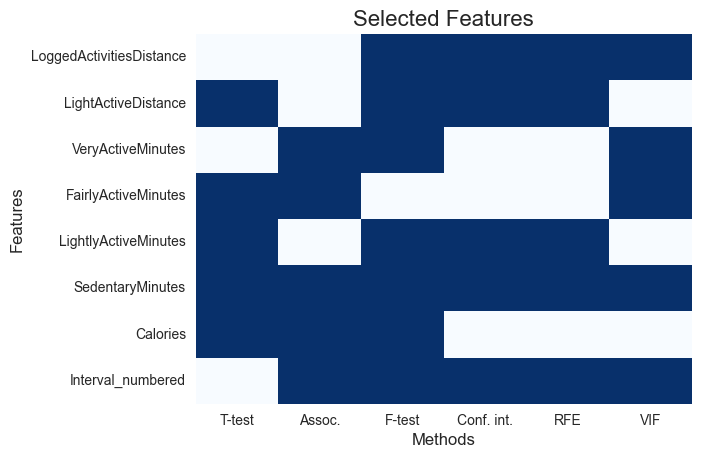

In [39]:
# Create a dictionary with the selected features and the methods that selected them
selected_features_dict = {
    'Feature': selected_features,
    'T-test': [True if feature in selected_features_t else False for feature in selected_features],
    'Assoc.': [True if feature in top_features else False for feature in selected_features],
    'F-test': [True if feature in selected_features_f else False for feature in selected_features],
    'Conf. int.': [True if feature in selected_features_confint else False for feature in selected_features],
    'RFE': [True if feature in selected_features_rfe else False for feature in selected_features],
    'VIF': [True if feature in selected_features_vif else False for feature in selected_features],
}

# Create a pandas DataFrame with the selected features as rows and methods as columns
selected_features_table = pd.DataFrame(selected_features_dict).set_index('Feature')

# Create the heatmap using seaborn
sns.heatmap(selected_features_table, cmap='Blues', cbar=False)

# Set the title and axis labels
plt.title('Selected Features', fontsize=16)
plt.xlabel('Methods', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Rotate the y-axis labels for better readability
plt.yticks(rotation=0)

# Show the plot
plt.show()


In [40]:
# Count the number of True values for each column and sort in descending order
votes = selected_features_table.sum(axis=1).sort_values(ascending=False)

# Select the top 5 features with the most votes
selected_features_final = votes[:5].index.tolist()
print(f'Selected features (Final): {list(selected_features_final)}')
print(f'Dropped features (Final): {[x for x in selected_features if x not in selected_features_final]}')


Selected features (Final): ['SedentaryMinutes', 'Interval_numbered', 'LoggedActivitiesDistance', 'LightActiveDistance', 'LightlyActiveMinutes']
Dropped features (Final): ['VeryActiveMinutes', 'FairlyActiveMinutes', 'Calories']


In [41]:
selected_features_final_indices = [df_important_new.drop(columns=['Average Heart Rate']
                                                          ).columns.get_loc(col) for col in selected_features_final]
X_train_new_selected = X_train_new_std[:, selected_features_final_indices]
X_test_new_selected = X_test_new_std[:, selected_features_final_indices]

In [42]:
# Create the linear regression model
lr = LinearRegression()

# Fit the model to the training set without feature selection
lr.fit(X_train_new, y_train_new)

# Compute R-squared on the training set without feature selection
train_score_full = lr.score(X_train_new, y_train_new)

# Compute R-squared on the test set without feature selection
test_score_full = lr.score(X_test_new, y_test_new)

# Fit the model to the training set with feature selection
lr.fit(X_train_new_selected, y_train_new)

# Compute R-squared on the training set with feature selection
train_score_selected = lr.score(X_train_new_selected, y_train_new)

# Compute R-squared on the test set with feature selection
test_score_selected = lr.score(X_test_new_selected, y_test_new)

# Print the R-squared scores
print(f'R-squared score on training (all): {train_score_full:.4f}')
print(f'R-squared score on training set (selected features): {train_score_selected:.4f}')

print(f'\nR-squared score on test set (all): {test_score_full:.4f}')
print(f'R-squared score on test set (selected features): {test_score_selected:.4f}')

R-squared score on training (all): 0.1535
R-squared score on training set (selected features): 0.1501

R-squared score on test set (all): 0.1588
R-squared score on test set (selected features): 0.1571


The feature elimination did not improve model performance, but it didn't damage it either.<br>
In fact, the voting method has been seen to be generally more effective compared to selecting features based on individual methods (Result not shown). 

Predictions are faster now due to reduced dimensionality.

# Phase III

## Classification Analysis

### Prepare data

We divide 'Average Heart Rate' into classes for classification

#### Method 1: Using KNN

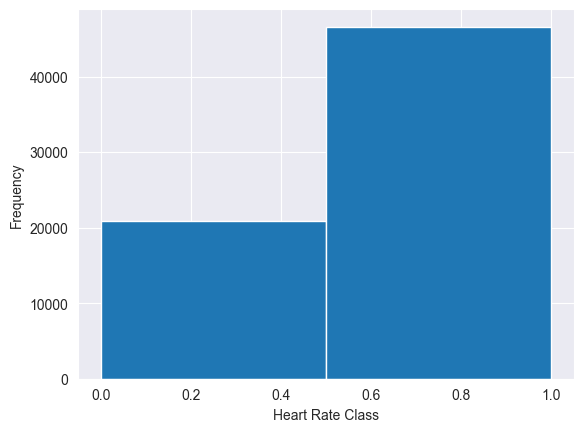

In [86]:
# Create Heart Rate Classes using KNN
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(df_new[['Average Heart Rate']])
df_new['Heart Rate Class'] = kmeans.labels_

#Plot the histogram
plt.hist(df_new['Heart Rate Class'], bins=2)
plt.xlabel('Heart Rate Class')
plt.ylabel('Frequency')
plt.show()

#### Method 2: Equal-width bins

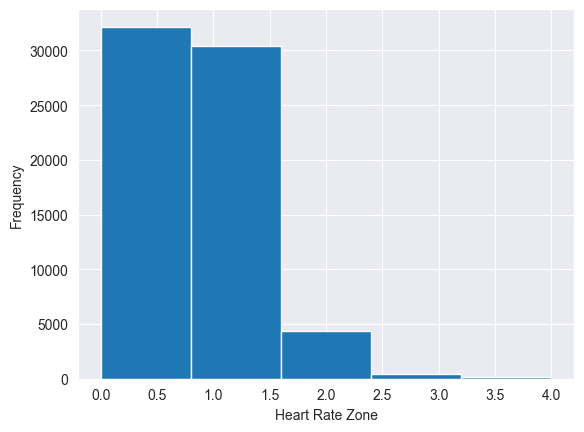

In [87]:
# Create Heart Rate Zones by dividing Average Heart Rate into equal-width bins
df_new['Heart Rate Zone'] = pd.cut(df_new['Average Heart Rate'], bins=5, labels=False)

#Plot the histogram
plt.hist(df_new['Heart Rate Zone'], bins=5)
plt.xlabel('Heart Rate Zone')
plt.ylabel('Frequency')
plt.show()

Users performing in high heart rate zones are rare in the dataset

### Set up

We consider 'Heart Rate Class' as our (binary) classification target

In [45]:
classification_features = ['TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories', 'Interval_numbered']
classification_target = 'Heart Rate Class'

In [46]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_new[classification_features], df_new[classification_target], test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()

# fit the scaler to the training data
scaler.fit(X_train)

# transform the training and test data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Modeling

Confusion matrix for DecisionTreeClassifier:
[[3301  799]
 [ 870 8534]]
Classification report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      4100
           1       0.91      0.91      0.91      9404

    accuracy                           0.88     13504
   macro avg       0.85      0.86      0.85     13504
weighted avg       0.88      0.88      0.88     13504

Confusion matrix for LogisticRegression:
[[1448 2652]
 [ 806 8598]]
Classification report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.64      0.35      0.46      4100
           1       0.76      0.91      0.83      9404

    accuracy                           0.74     13504
   macro avg       0.70      0.63      0.64     13504
weighted avg       0.73      0.74      0.72     13504

Confusion matrix for KNeighborsClassifier:
[[3243  857]
 [ 653 8751]]
Classification report for KNeighborsClas

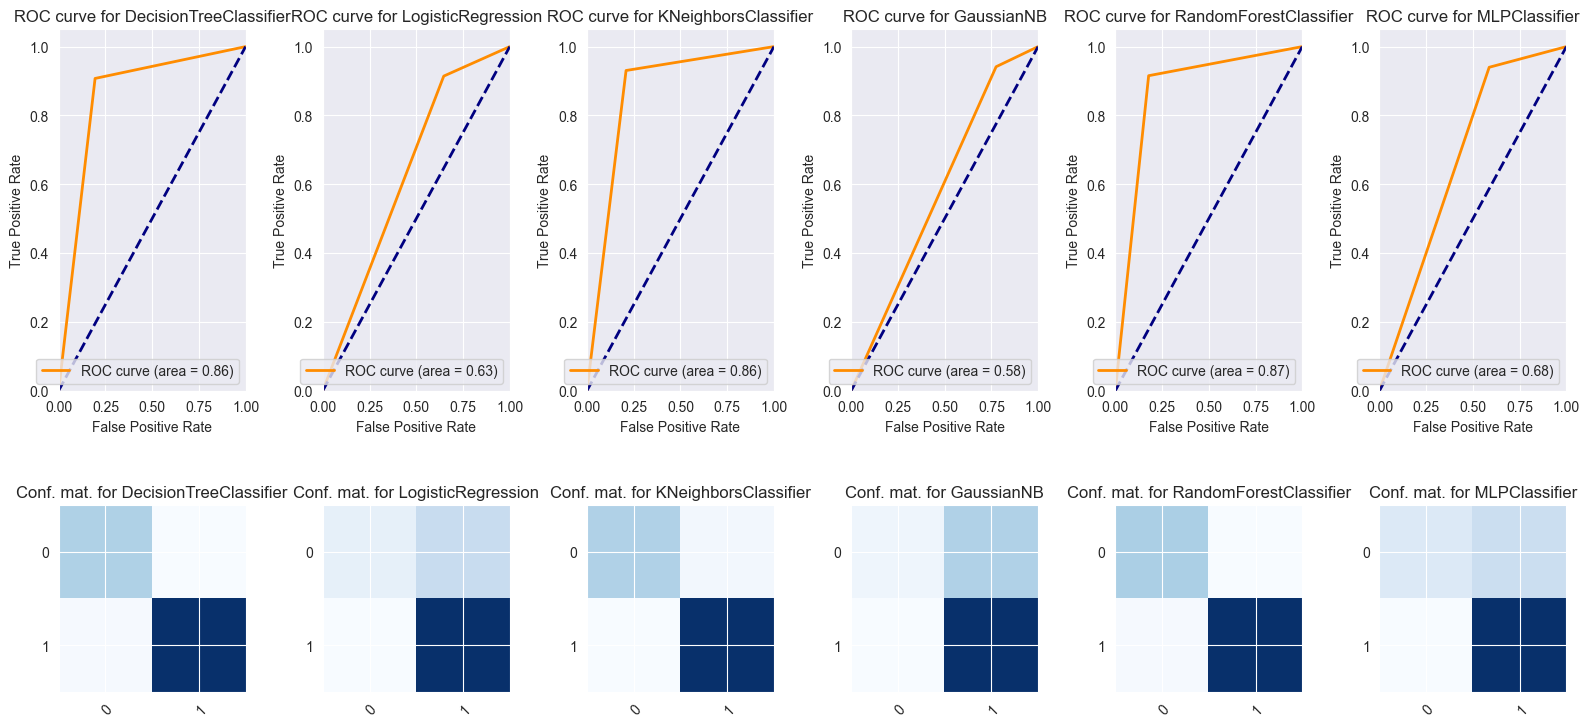

In [94]:
classifiers = [DecisionTreeClassifier(), LogisticRegression(), KNeighborsClassifier(), 
               GaussianNB(), RandomForestClassifier(), MLPClassifier(alpha=1, max_iter=1000)]

fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16, 8))
axes = axes.ravel()

for i, clf in enumerate(classifiers):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix for {}:\n{}".format(type(clf).__name__, cm))
    print("Classification report for {}:\n{}".format(type(clf).__name__, classification_report(y_test, y_pred)))
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    lw = 2
    axes[i].plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    axes[i].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title('ROC curve for {}'.format(type(clf).__name__))
    axes[i].legend(loc="lower right")
    
    # Add confusion matrix subplot
    axes[i+6].imshow(cm, cmap=plt.cm.Blues)
    classes = clf.classes_
    tick_marks = np.arange(len(classes))
    axes[i+6].set_xticks(tick_marks)
    axes[i+6].set_xticklabels(classes)
    axes[i+6].set_yticks(tick_marks)
    axes[i+6].set_yticklabels(classes)
    axes[i+6].set_title("Conf. mat. for {}".format(type(clf).__name__))
    plt.setp(axes[i+6].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()

Note: We have found that the SVM takes an inordinate time to calculate the decision boundary for our classification problem. For this reason we have excluded this model even though the requirements asks us to perform the classification using SVM.

### Conclusion

# Phase IV

### K-Means Algorithm

We use the elbow method to find the optimal number of clusters

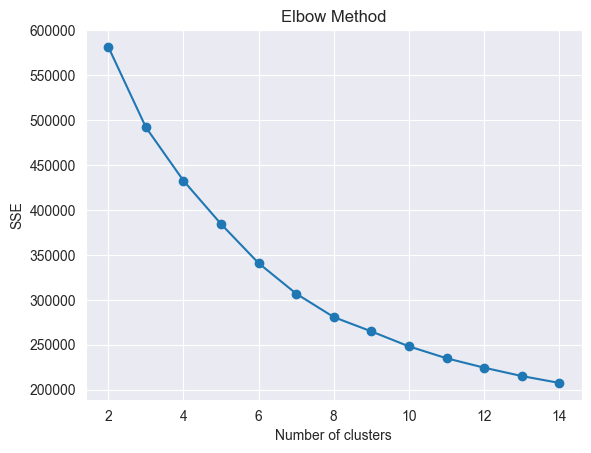

In [60]:
# Define the range of cluster numbers to evaluate
num_clusters_range = range(2, 15)

# Compute the within-cluster sum of squares (SSE) for each cluster number
sse = []
for k in num_clusters_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_train)
    sse.append(kmeans.inertia_)

# Plot the SSE versus the number of clusters
plt.plot(num_clusters_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

We choose 6 to be our number of clusters

In [62]:
# Define the number of clusters you want to create
num_clusters = 6

# Initialize the K-Means algorithm
kmeans = KMeans(n_clusters=num_clusters, n_init=10)

# Fit the K-Means algorithm to the training data
kmeans.fit(X_train)

# Predict the cluster labels for the test data
y_pred = kmeans.predict(X_test)

# Compute the silhouette score for the clustering
silhouette_avg = silhouette_score(X_test, y_pred)

# Print the silhouette score
print("The silhouette score is {:.2f}".format(silhouette_avg))

The silhouette score is 0.25


Observations about the K-Means clustering analysis:

- The clusters are not that well-separated.
- The silhouette score is 0.25, which does not indicate good clustering.

### DBSCAN Algorithm

In [83]:
# Define the DBSCAN object
dbscan = DBSCAN(eps=3, min_samples=2)

# Fit the DBSCAN model to the training data and predict the cluster labels for the test data
y_pred = dbscan.fit_predict(X_test)

# Compute the adjusted Rand score for the clustering
ari = adjusted_rand_score(y_test, y_pred)

print("Adjusted Rand Score:", ari)

Adjusted Rand Score: 0.07596615533952375


Observations about the DBSCAN clustering analysis
- The clusters are irregularly shaped.
- The adjusted Rand score is 0.076, indicating almost random clustering. 
- But at least the score is not negative, so the clusterings are not dissimilar.

### Apriori Algorithm

In [101]:
# Create itemset for association rule mining
df_itemsets = df_new[['Interval_numbered', 'Heart Rate Zone']]

# convert the categorical data to binary encoding
df_binary = pd.get_dummies(df_itemsets, columns=['Interval_numbered', 'Heart Rate Zone'])

df_binary

,Interval_numbered_1,Interval_numbered_2,Interval_numbered_3,Interval_numbered_4,Interval_numbered_5,Interval_numbered_6,Interval_numbered_7,Interval_numbered_8,Interval_numbered_9,Interval_numbered_10,...,Interval_numbered_284,Interval_numbered_285,Interval_numbered_286,Interval_numbered_287,Interval_numbered_288,Heart Rate Zone_0,Heart Rate Zone_1,Heart Rate Zone_2,Heart Rate Zone_3,Heart Rate Zone_4
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67513,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
67514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
67515,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
67516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [119]:
# Define the minimum support threshold
min_support = 0.003

# Generate the frequent itemsets using the Apriori algorithm
frequent_itemsets = apriori(df_binary, min_support=min_support, use_colnames=True)

## Print the frequent itemsets
# print(frequent_itemsets)

/Users/me/opt/anaconda3/envs/data/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [120]:
# Generate the association rules from the frequent itemsets
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.005)

# Print the rules
print(rules)

              antecedents             consequents  antecedent support  \
0  (Interval_numbered_31)     (Heart Rate Zone_0)            0.004725   
1     (Heart Rate Zone_0)  (Interval_numbered_31)            0.476391   
2  (Interval_numbered_47)     (Heart Rate Zone_0)            0.004665   
3     (Heart Rate Zone_0)  (Interval_numbered_47)            0.476391   
4  (Interval_numbered_48)     (Heart Rate Zone_0)            0.004665   
5     (Heart Rate Zone_0)  (Interval_numbered_48)            0.476391   
6     (Heart Rate Zone_0)  (Interval_numbered_49)            0.476391   
7  (Interval_numbered_49)     (Heart Rate Zone_0)            0.004665   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.476391  0.003036    0.642633  1.348960  0.000785    1.465185   
1            0.004725  0.003036    0.006373  1.348960  0.000785    1.001659   
2            0.476391  0.003021    0.647619  1.359426  0.000799    1.485916   
3            0.004665  0.0

Observations about the association rule mining:

- We have found some antecedents -> consequent pairs for the of running inteval number and heart rate zone